Erreur quadratique moyenne :24.579663011703406


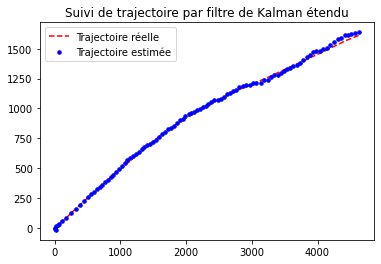

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

T_e = 1
T = 100
sigma_Q = 1
sigma_angle = (np.pi/180)
sigma_dist = 10
F = np.array([[1, T_e, 0, 0], [0, 1, 0, 0], [0, 0, 1, T_e], [0, 0, 0, 1]])
R = np.array([[sigma_angle**2, 0], [0, sigma_dist**2]])
H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
Q = sigma_Q**2*np.array([[(T_e**3)/3, (T_e**2)/2, 0, 0], [(T_e**2)/2, T_e, 0, 0], [0, 0, (T_e**3)/3, (T_e**2)/2], [0, 0, (T_e**2)/2, T_e]])
U = np.random.multivariate_normal(np.zeros(4), Q)
V = np.random.multivariate_normal(np.zeros(2), R)
x_init0 = np.array([3, 40, -4, 20])
x_init = np.transpose(x_init0)
x_kalm = x_init
P_kalm = np.identity(4)


def g(vec):
  return np.array([np.arctan((vec[2])/(vec[0])), np.sqrt(vec[0]**2 + vec[2]**2)])

def creer_trajectoire(F, Q, x_init, T): 
  vecteur_x = np.zeros((4, T))
  vecteur_x[:, 0] = x_init
  for k in range(1, T, 1) : 
    U = np.random.multivariate_normal(np.zeros(4), Q)
    vecteur_x[:, k] = F@vecteur_x[:, k-1] + U
  return vecteur_x

vecteur_x = creer_trajectoire(F, Q, x_init, T)

##je cree un vecteur_xbis a deux composantes en polaires 
def changement(vecteur_x): 
  vecteur_xbis = np.zeros((2, T))
  for k in range(T): 
    vecteur_xbis[:, k] = g(vecteur_x[:, k])
  return vecteur_xbis

vecteur_xbis = changement(vecteur_x)

def creer_observations_radar(R, vecteur_x, T):
  vecteur_y = np.zeros((2, T))
  for k in range(T) : 
    V = np.random.multivariate_normal(np.zeros(2), R)
    vecteur_y[:, k] = g(vecteur_x[:, k]) + V
  return vecteur_y

vecteur_y = creer_observations_radar(R, vecteur_x, T)


##je trace vecteur_xbis le vecteur_x en polaire qui est vecteur_xbis et vecteur_y aussi en polaire 
#plt.plot(vecteur_xbis[0, :], vecteur_xbis[1, :], color="red")
#plt.plot(vecteur_y[0, :], vecteur_y[1, :], color="blue")
#plt.show()


def jacobien(x) : 
  p_x = x[0]
  p_y = x[2]
  dx_dx = -p_y/(p_x**2 + p_y**2)
  dx_dy = p_x/(p_x**2 + p_y**2)
  dy_dx = p_x/np.sqrt(p_x**2 + p_y**2)
  dy_dy = p_y/np.sqrt(p_x**2 + p_y**2)
  return np.array([[dx_dx, 0, dx_dy, 0], [dy_dx, 0, dy_dy, 0]])


def creer_observations_radar(R, vecteur_x, T):
  vecteur_y = np.zeros((2, T))
  for k in range(T) : 
    V = np.random.multivariate_normal(np.zeros(2), R)
    vecteur_y[:, k] = g(vecteur_x[:, k]) + V
  return vecteur_y


def filtre_kalman_radar(F, Q, R, vecteur_y, k, x_kalm_prec, P_kalm_prec):
  J = jacobien(x_kalm_prec)
  x_k_k_1 = F@x_kalm_prec
  #vecteur_ybis =np.zeros((2,100))
 # print(vecteur_ybis.shape)
  vecteur_ybis = vecteur_y[:, k] - g(x_k_k_1) + jacobien(x_k_k_1)@x_k_k_1  
  #print(vecteur_ybis.shape)
  p_k_k_1 = Q + F@P_kalm_prec@np.transpose(F)
  K = p_k_k_1@np.transpose(J)@np.linalg.inv((J@p_k_k_1@np.transpose(J) + R))
  P_kalm_k = (np.identity(4) - K@J)@p_k_k_1
  x_kalm_k = x_k_k_1 + K@(vecteur_ybis-J@x_k_k_1) 
  return(x_kalm_k, P_kalm_k)

x_kalm_k, P_kalm_k = filtre_kalman_radar(F, Q, R, vecteur_y, 0, x_init, np.identity(4))
#print(x_kalm_k, P_kalm_k)


def test_kalman2(vecteur_y_radar,F,Q,R,T,x_init) :
    x_est2 = np.zeros((4,T))
    x_est2[:,0] = x_init.reshape(4,)
    P_kalm_prec = np.eye(4)
    x_kalm_prec = x_init
    
    for j in range(1, T) :
        x_kalm_prec, P_kalm_prec =  filtre_kalman_radar(F, Q, R, vecteur_y, j, x_kalm_prec, P_kalm_prec)
        x_est2[:,j] = x_kalm_prec.reshape(4,)
        #print(x_kalm.shape)

    
    return x_est2

x_est2  = test_kalman2(vecteur_y,F,Q,R,T,x_init)

def  err_quadra(k,vecteur_x, x_est ) :
    return np.transpose((vecteur_x[:,k] - x_est[:,k]))@(vecteur_x[:,k] - x_est[:,k])

def err_moy(T,vecteur_x, x_est) :
    s=0
    for i in range(1,T) :
        s+= (err_quadra(i,vecteur_x, x_est ))**(1/2)
    return (1/T)*s
print("Erreur quadratique moyenne :" + str(err_moy(T,vecteur_x, x_est2)))

plt.plot(vecteur_x[0,:],vecteur_x[2,:], 'r--', label="Trajectoire réelle")
plt.plot(x_est2[0,:], x_est2[2,:], 'bo', markersize=3.5, label="Trajectoire estimée")
plt.legend()

plt.title("Suivi de trajectoire par filtre de Kalman étendu")




plt.show()




